In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from PIL import Image

import keras
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Layer
import keras.backend as K


In [2]:
class MiniBatchDiscrimination(Layer):
    def __init__(self, num_kernels, kernel_dim, **kwargs):
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        super(MiniBatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='kernel',
                                 shape=(input_shape[-1], self.num_kernels * self.kernel_dim),
                                 initializer='uniform',
                                 trainable=True)
        super(MiniBatchDiscrimination, self).build(input_shape)

    def call(self, x):
        activation = K.dot(x, self.W)
        activation = K.reshape(activation, (-1, self.num_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.num_kernels)

In [3]:
BASE_DIR1 = "/kaggle/input/gananime-lite/out2"
image_paths = []
max_images = 3000
for image_name in os.listdir(BASE_DIR1)[:max_images]:
    if image_name.lower().endswith(('.png', '.jpg')):
        image_path = os.path.join(BASE_DIR1, image_name)
        image_paths.append(image_path)

target_size = (128, 128)
images = [np.array(Image.open(path).resize(target_size)) for path in tqdm(image_paths)]
images = np.array(images)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [4]:

class DCGAN():
    def __init__(self):
        self.img_shape = (128, 128, 3)
        self.noise_size = 256

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)

        self.discriminator.trainable = False

        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined.summary()

    def build_generator(self):
        epsilon = 0.00001
        noise_shape = (self.noise_size,)

        model = Sequential()

        model.add(Dense(8 * 8 * 256, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((8, 8, 256)))

        model.add(Conv2DTranspose(256, kernel_size=[4, 4], strides=[2, 2], padding="same",
                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        
        model.add(Conv2DTranspose(128, kernel_size=[4, 4], strides=[2, 2], padding="same",
                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=[4, 4], strides=[2, 2], padding="same",
                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(32, kernel_size=[4, 4], strides=[2, 2], padding="same",
                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=[4, 4], strides=[1, 1], padding="same",
                                  kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02)))

        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(128, (3, 3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.3))

        # Mini-batch discrimination layer
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(MiniBatchDiscrimination(num_kernels=64, kernel_dim=8))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)

        mean_d_loss = [0, 0]
        mean_g_loss = 0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))
                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)

            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss

            if epoch % metrics_update == 0:
                print("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (
                    epoch, mean_d_loss[0] / metrics_update, 100 * mean_d_loss[1] / metrics_update,
                    mean_g_loss / metrics_update))
                mean_d_loss = [0, 0]
                mean_g_loss = 0

            if epoch % save_images == 0:
                self.save_images(epoch)

            if epoch % save_model == 0:
                generator_file = "generator_%d.h5" % epoch
                self.generator.save(generator_file)

    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5, figsize=(8, 8))

        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[5 * i + j])
                axs[i, j].axis('off')

        plt.show()

        fig.savefig("anime_DCGAN/Train_%d.png" % epoch)
        plt.close()


In [5]:
!mkdir anime_DCGAN

In [6]:
dcgan = DCGAN()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                       

1/1 [==============================] - 6s 6s/step


2023-12-28 07:05:03.834129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-28 07:05:06.613297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/model/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0 [Discriminator loss: 0.148199, acc.: 0.48%] [Generator loss: 0.002321]
1/1 [==============================] - 0s 226ms/step


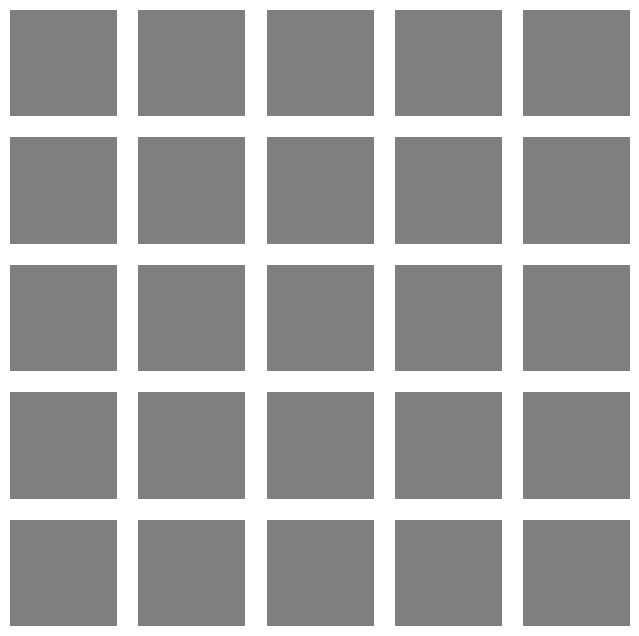

1/1 [==============================] - 0s 18ms/step
100 [Discriminator loss: 0.283444, acc.: 90.70%] [Generator loss: 6.200609]
1/1 [==============================] - 0s 17ms/step
200 [Discriminator loss: 0.325357, acc.: 88.02%] [Generator loss: 6.306943]
1/1 [==============================] - 0s 16ms/step
300 [Discriminator loss: 0.367896, acc.: 85.02%] [Generator loss: 6.761073]
1/1 [==============================] - 0s 18ms/step
400 [Discriminator loss: 0.327852, acc.: 86.80%] [Generator loss: 6.149913]
1/1 [==============================] - 0s 17ms/step
500 [Discriminator loss: 0.316570, acc.: 86.69%] [Generator loss: 7.164665]
1/1 [==============================] - 0s 17ms/step


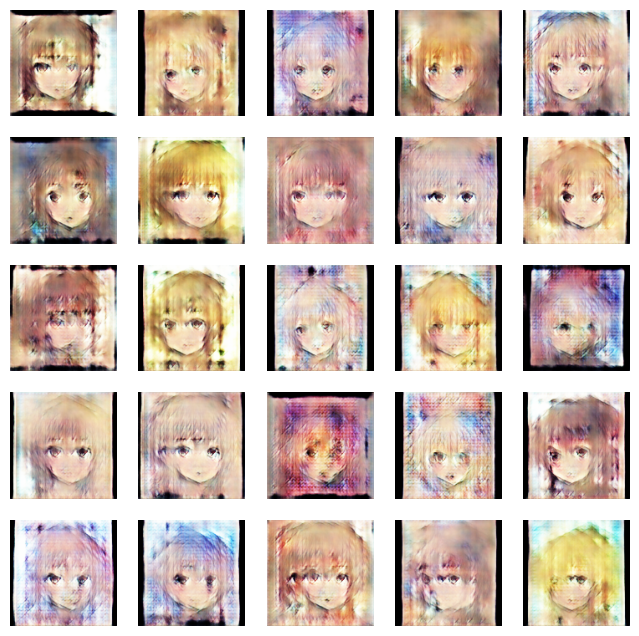

1/1 [==============================] - 0s 17ms/step
600 [Discriminator loss: 0.339470, acc.: 86.66%] [Generator loss: 6.474345]
1/1 [==============================] - 0s 16ms/step
700 [Discriminator loss: 0.345518, acc.: 85.62%] [Generator loss: 6.834278]
1/1 [==============================] - 0s 17ms/step
800 [Discriminator loss: 0.260667, acc.: 89.41%] [Generator loss: 7.134562]
1/1 [==============================] - 0s 20ms/step
900 [Discriminator loss: 0.281952, acc.: 89.06%] [Generator loss: 6.407532]
1/1 [==============================] - 0s 17ms/step
1000 [Discriminator loss: 0.285482, acc.: 88.34%] [Generator loss: 7.480153]
1/1 [==============================] - 0s 18ms/step


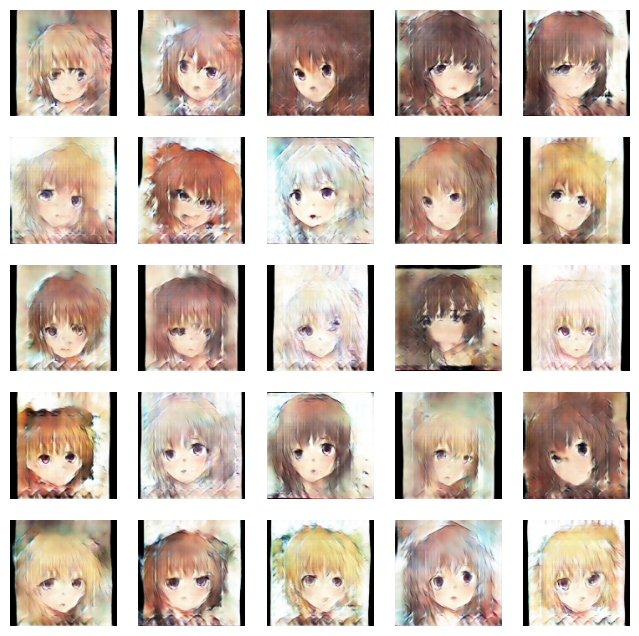

1/1 [==============================] - 0s 16ms/step
1100 [Discriminator loss: 0.233009, acc.: 90.53%] [Generator loss: 7.914296]
1/1 [==============================] - 0s 19ms/step
1200 [Discriminator loss: 0.216300, acc.: 91.36%] [Generator loss: 8.111188]
1/1 [==============================] - 0s 17ms/step
1300 [Discriminator loss: 0.241945, acc.: 90.20%] [Generator loss: 7.833084]
1/1 [==============================] - 0s 17ms/step
1400 [Discriminator loss: 0.253319, acc.: 90.22%] [Generator loss: 8.107419]
1/1 [==============================] - 0s 20ms/step
1500 [Discriminator loss: 0.253892, acc.: 89.77%] [Generator loss: 7.538617]
1/1 [==============================] - 0s 19ms/step


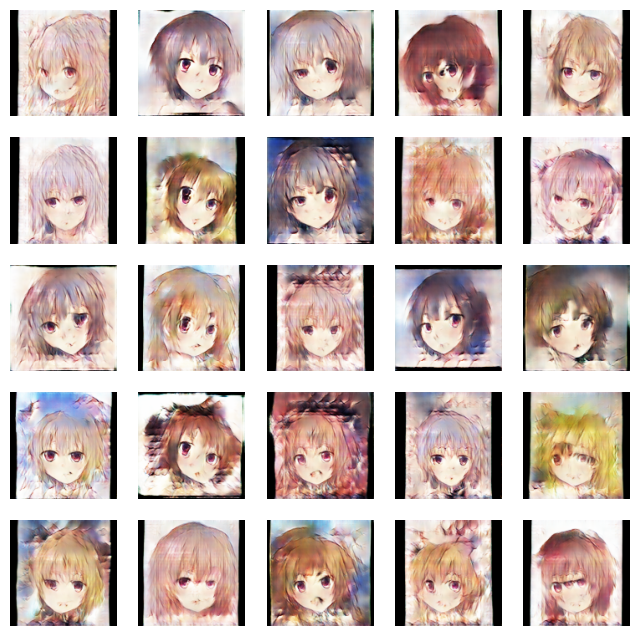

1/1 [==============================] - 0s 18ms/step
1600 [Discriminator loss: 0.177034, acc.: 93.05%] [Generator loss: 8.486314]
1/1 [==============================] - 0s 18ms/step
1700 [Discriminator loss: 0.242026, acc.: 90.61%] [Generator loss: 7.916615]
1/1 [==============================] - 0s 17ms/step
1800 [Discriminator loss: 0.209028, acc.: 92.19%] [Generator loss: 8.000060]
1/1 [==============================] - 0s 18ms/step
1900 [Discriminator loss: 0.171759, acc.: 93.42%] [Generator loss: 8.290645]
1/1 [==============================] - 0s 25ms/step
2000 [Discriminator loss: 0.220665, acc.: 91.36%] [Generator loss: 8.832995]
1/1 [==============================] - 0s 18ms/step


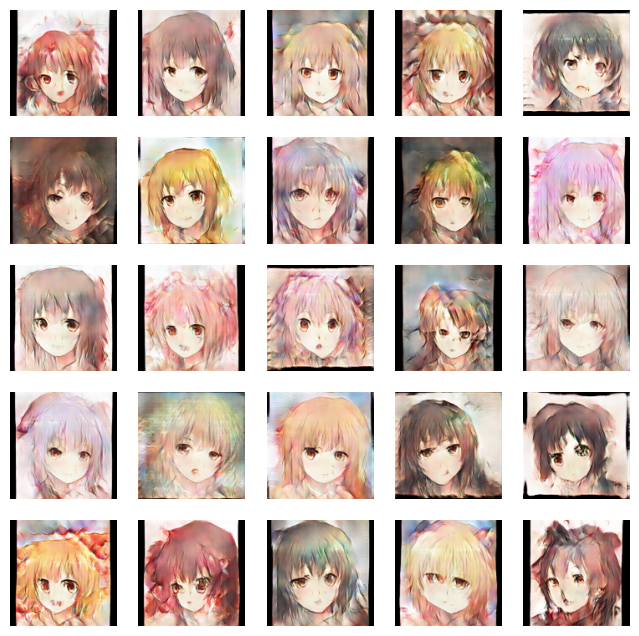

1/1 [==============================] - 0s 19ms/step
2100 [Discriminator loss: 0.136157, acc.: 94.67%] [Generator loss: 8.881912]
1/1 [==============================] - 0s 18ms/step
2200 [Discriminator loss: 0.157255, acc.: 93.98%] [Generator loss: 8.978920]
1/1 [==============================] - 0s 17ms/step
2300 [Discriminator loss: 0.247656, acc.: 91.00%] [Generator loss: 7.426670]
1/1 [==============================] - 0s 17ms/step
2400 [Discriminator loss: 0.207131, acc.: 92.66%] [Generator loss: 8.416652]
1/1 [==============================] - 0s 19ms/step
2500 [Discriminator loss: 0.153157, acc.: 94.39%] [Generator loss: 8.652088]
1/1 [==============================] - 0s 21ms/step


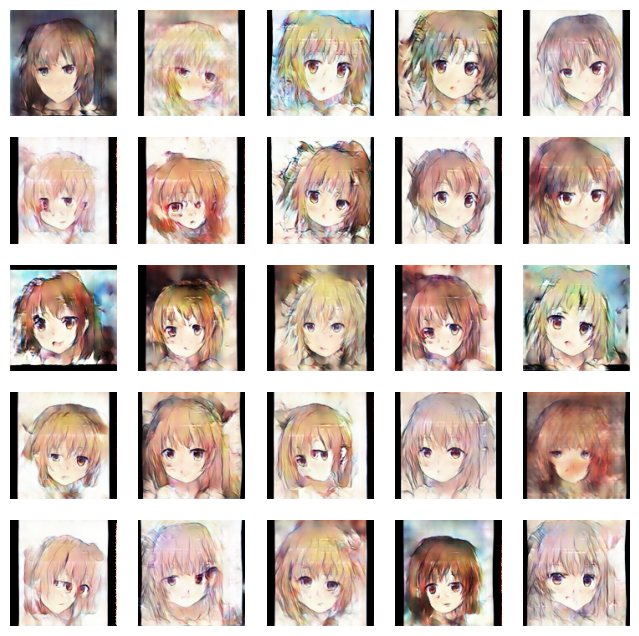

1/1 [==============================] - 0s 18ms/step
2600 [Discriminator loss: 0.159740, acc.: 94.44%] [Generator loss: 9.207196]
1/1 [==============================] - 0s 19ms/step
2700 [Discriminator loss: 0.109887, acc.: 96.25%] [Generator loss: 9.901258]
1/1 [==============================] - 0s 17ms/step
2800 [Discriminator loss: 0.203792, acc.: 93.62%] [Generator loss: 8.985067]
1/1 [==============================] - 0s 19ms/step
2900 [Discriminator loss: 0.123986, acc.: 95.44%] [Generator loss: 9.263956]
1/1 [==============================] - 0s 22ms/step
3000 [Discriminator loss: 0.160129, acc.: 94.55%] [Generator loss: 8.980784]
1/1 [==============================] - 0s 18ms/step


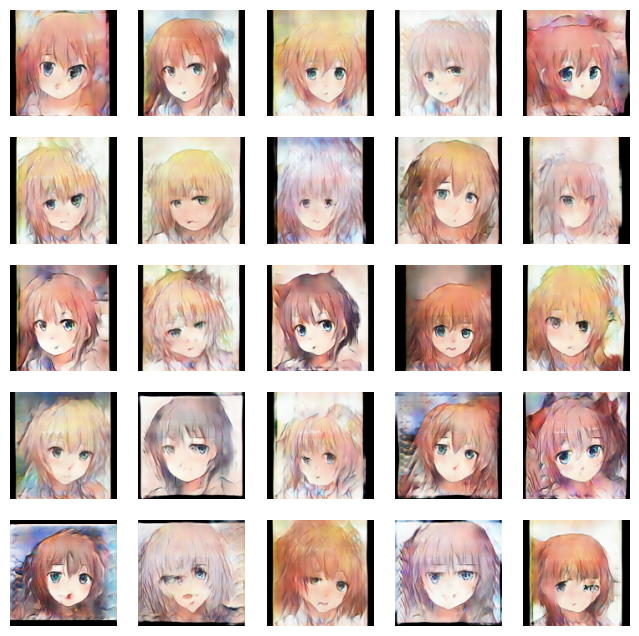

1/1 [==============================] - 0s 18ms/step
3100 [Discriminator loss: 0.074839, acc.: 97.34%] [Generator loss: 10.693903]
1/1 [==============================] - 0s 17ms/step
3200 [Discriminator loss: 0.139239, acc.: 94.92%] [Generator loss: 9.521838]
1/1 [==============================] - 0s 18ms/step
3300 [Discriminator loss: 0.188299, acc.: 93.28%] [Generator loss: 9.637669]
1/1 [==============================] - 0s 16ms/step
3400 [Discriminator loss: 0.117222, acc.: 96.12%] [Generator loss: 9.204506]
1/1 [==============================] - 0s 18ms/step
3500 [Discriminator loss: 0.162127, acc.: 94.55%] [Generator loss: 8.857181]
1/1 [==============================] - 0s 19ms/step


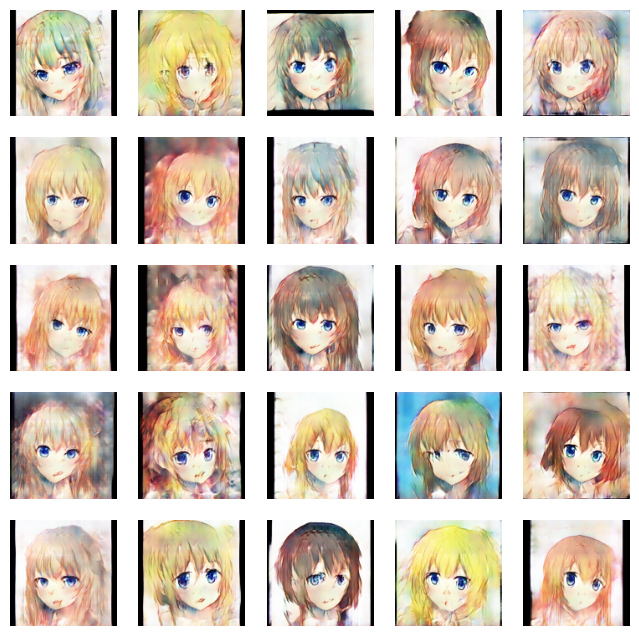

1/1 [==============================] - 0s 17ms/step
3600 [Discriminator loss: 0.066176, acc.: 97.83%] [Generator loss: 8.850311]
1/1 [==============================] - 0s 18ms/step
3700 [Discriminator loss: 0.124204, acc.: 95.81%] [Generator loss: 9.719371]
1/1 [==============================] - 0s 17ms/step
3800 [Discriminator loss: 0.132828, acc.: 96.16%] [Generator loss: 9.737187]
1/1 [==============================] - 0s 18ms/step
3900 [Discriminator loss: 0.138394, acc.: 94.86%] [Generator loss: 9.462733]
1/1 [==============================] - 0s 19ms/step
4000 [Discriminator loss: 0.127676, acc.: 95.59%] [Generator loss: 9.850979]
1/1 [==============================] - 0s 18ms/step


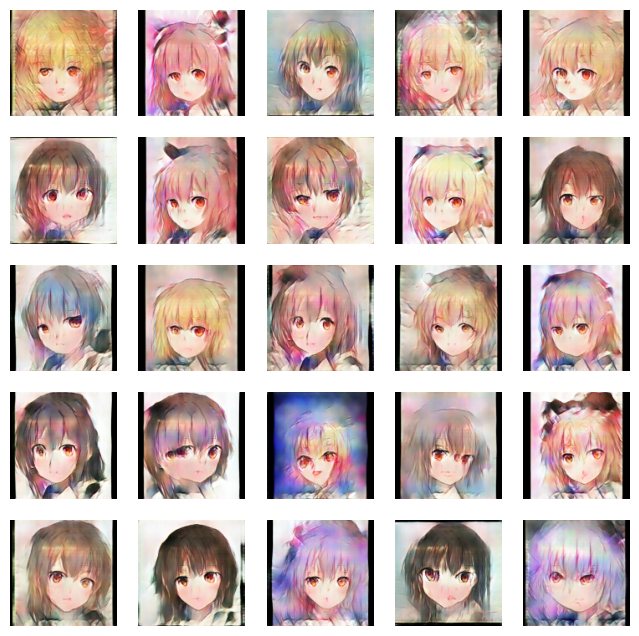

1/1 [==============================] - 0s 17ms/step
4100 [Discriminator loss: 0.098366, acc.: 96.75%] [Generator loss: 10.380673]
1/1 [==============================] - 0s 19ms/step
4200 [Discriminator loss: 0.089023, acc.: 97.28%] [Generator loss: 9.329192]
1/1 [==============================] - 0s 17ms/step
4300 [Discriminator loss: 0.076481, acc.: 97.61%] [Generator loss: 8.795191]
1/1 [==============================] - 0s 17ms/step
4400 [Discriminator loss: 0.052103, acc.: 98.31%] [Generator loss: 10.132425]
1/1 [==============================] - 0s 17ms/step
4500 [Discriminator loss: 0.133804, acc.: 95.03%] [Generator loss: 9.363911]
1/1 [==============================] - 0s 18ms/step


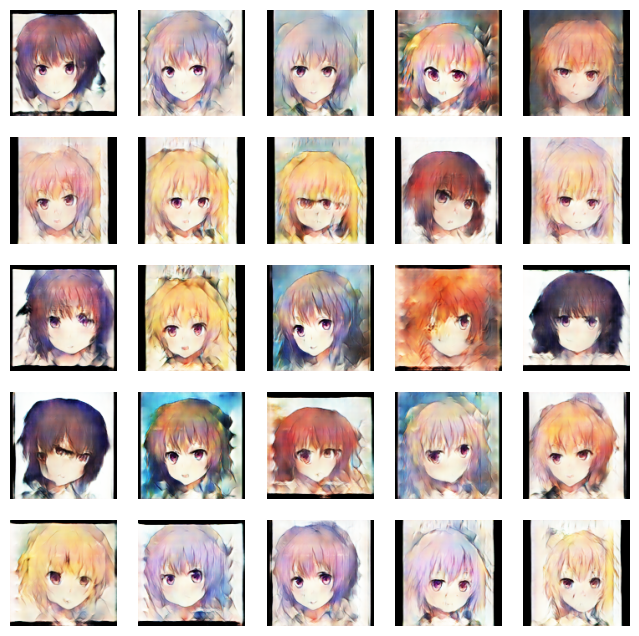

1/1 [==============================] - 0s 19ms/step
4600 [Discriminator loss: 0.036279, acc.: 98.80%] [Generator loss: 11.118233]
1/1 [==============================] - 0s 18ms/step
4700 [Discriminator loss: 0.009629, acc.: 99.70%] [Generator loss: 10.555311]
1/1 [==============================] - 0s 17ms/step
4800 [Discriminator loss: 0.049606, acc.: 98.45%] [Generator loss: 13.276298]
1/1 [==============================] - 0s 17ms/step
4900 [Discriminator loss: 0.015808, acc.: 99.55%] [Generator loss: 13.617219]
1/1 [==============================] - 0s 18ms/step
5000 [Discriminator loss: 0.030299, acc.: 98.89%] [Generator loss: 13.127825]
1/1 [==============================] - 0s 19ms/step


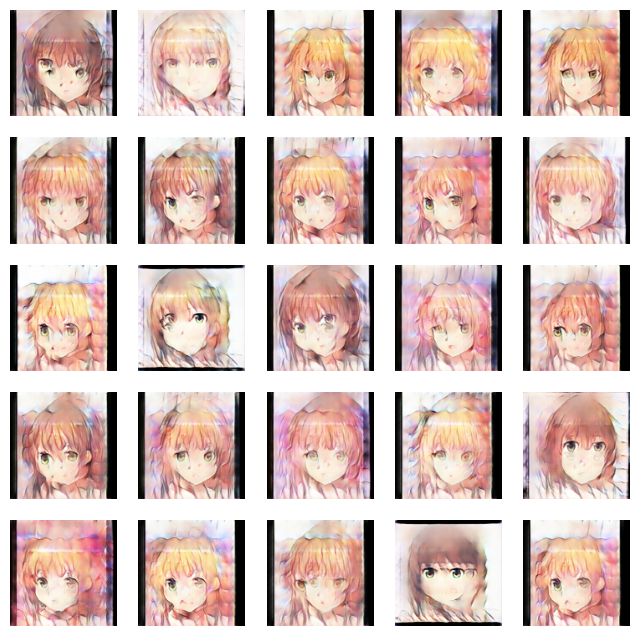

1/1 [==============================] - 0s 17ms/step
5100 [Discriminator loss: 0.026759, acc.: 98.98%] [Generator loss: 13.341616]
1/1 [==============================] - 0s 21ms/step
5200 [Discriminator loss: 0.032613, acc.: 98.84%] [Generator loss: 12.790801]
1/1 [==============================] - 0s 19ms/step
5300 [Discriminator loss: 0.061331, acc.: 97.91%] [Generator loss: 10.428733]
1/1 [==============================] - 0s 18ms/step
5400 [Discriminator loss: 0.028626, acc.: 99.05%] [Generator loss: 11.798286]
1/1 [==============================] - 0s 18ms/step
5500 [Discriminator loss: 0.007219, acc.: 99.88%] [Generator loss: 13.799566]
1/1 [==============================] - 0s 19ms/step


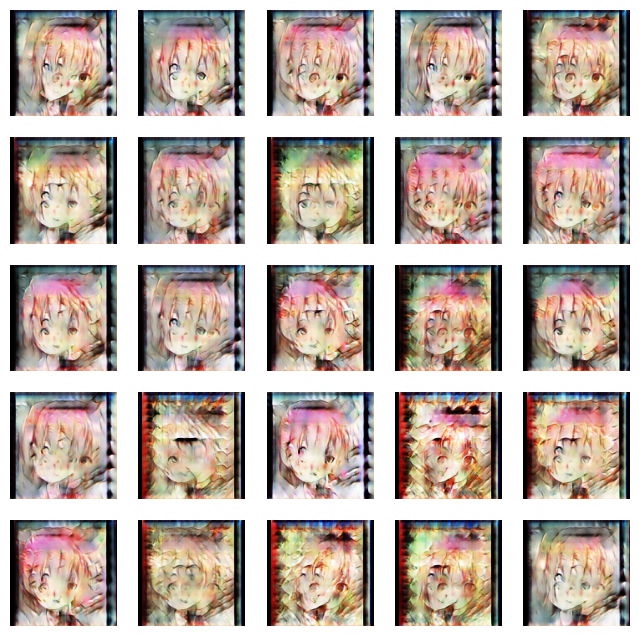

1/1 [==============================] - 0s 18ms/step
5600 [Discriminator loss: 0.005499, acc.: 99.88%] [Generator loss: 13.694972]
1/1 [==============================] - 0s 18ms/step
5700 [Discriminator loss: 0.004908, acc.: 99.84%] [Generator loss: 12.096893]
1/1 [==============================] - 0s 19ms/step
5800 [Discriminator loss: 0.002164, acc.: 99.95%] [Generator loss: 11.212965]
1/1 [==============================] - 0s 19ms/step
5900 [Discriminator loss: 0.001014, acc.: 100.00%] [Generator loss: 9.439649]
1/1 [==============================] - 0s 24ms/step
6000 [Discriminator loss: 0.001514, acc.: 99.98%] [Generator loss: 11.669412]
1/1 [==============================] - 0s 23ms/step


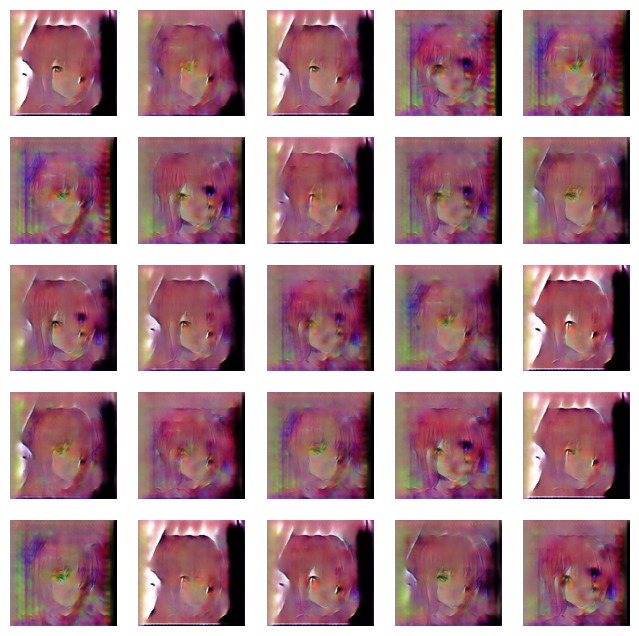

1/1 [==============================] - 0s 18ms/step
6100 [Discriminator loss: 0.001266, acc.: 99.98%] [Generator loss: 13.673459]
1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: 

In [7]:
dcgan.train(epochs=10001, batch_size=64, metrics_update=100, save_images=500, save_model=500)

In [8]:
!cd /kaggle/working
!ls

anime_DCGAN	   generator_2000.h5  generator_4000.h5  generator_5500.h5
generator_0.h5	   generator_2500.h5  generator_4500.h5  generator_6000.h5
generator_1000.h5  generator_3000.h5  generator_500.h5
generator_1500.h5  generator_3500.h5  generator_5000.h5


In [10]:
from IPython.display import FileLink 
FileLink(r'generator_4500.h5')

/kaggle/working/generator_4500.h5